# Случайные процессы. Прикладной поток.
## Практическое задание 8

Прогнозирование временных рядов.

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 8"`. Квадратные скобки обязательны, внутри них пробела быть не должно. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `8.N.ipynb` и `8.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* Никакой код из данного задания при проверке запускаться не будет.
* При выполнении задания можно использовать код с семинара. Во всяком случае ноутбук точно стоит посмотреть.

В файле `electricity.csv` (отсюда) cодержится информация о максимальном спросе на электричество (Consumption) в штате Виктория (Австралия) за $30$-минутные интервалы с $10$ января $2000$ в течении $115$ дней, а так же информация о температуре воздуха (Temperature) за эти же промежутки времени.

In [2]:
import warnings
import itertools
import scipy.stats as sps
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
from tqdm import tqdm_notebook
import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

plt.style.use('fivethirtyeight')

In [3]:
base_time = datetime.datetime(2000, 1, 10, 0, 0, 0)
print("Base datetime:", base_time)

Base datetime: 2000-01-10 00:00:00


In [4]:
df = pd.read_csv('electricity.csv', index_col=None)
df.head()

,Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
0,0,3853.475392,20.90,0,0,48
1,1,3683.014105,20.70,1,1,49
2,2,3912.324031,20.50,2,2,50
3,3,3783.881181,20.05,3,3,51
4,4,3554.257244,19.60,4,4,52


<span>1.</span> Нарисуйте графики временных рядов температуры и потребления электричества. Верно ли, что спрос на электричество зависит от температуры воздуха? Для ответа на вопрос используйте коэффициенты корреляции, учитывая условия их применимости.

Для начала проставим колонку дат для данных

In [5]:
df.set_index([pd.date_range(start=base_time, 
                            periods=len(df), 
                            freq='30T')], 
             inplace=True)
df.tail()

,Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
2000-05-03 21:30:00,5515,4410.631913,14.70,5515,43,187
2000-05-03 22:00:00,5516,4292.029885,14.60,5516,44,188
2000-05-03 22:30:00,5517,4231.380523,14.65,5517,45,189
2000-05-03 23:00:00,5518,4587.536047,14.70,5518,46,190
2000-05-03 23:30:00,5519,4540.230041,14.75,5519,47,191


Построим временной ряд для температуры

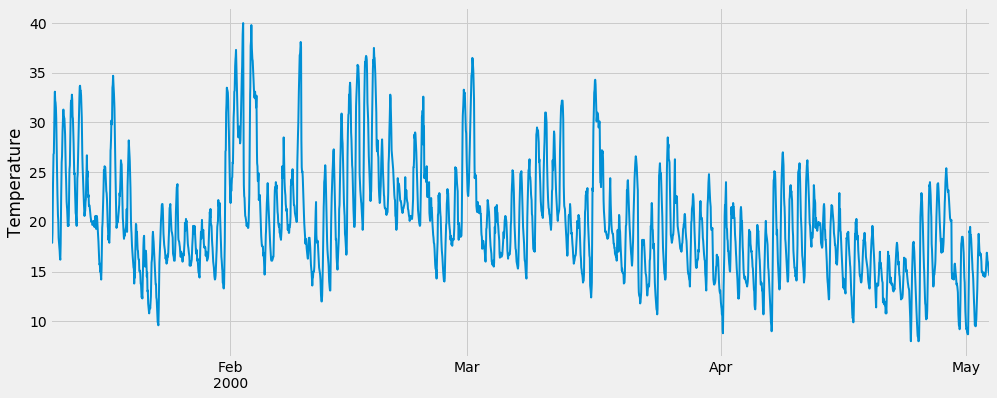

In [6]:
df['Temperature'].plot(figsize=(15, 6), 
                       lw=2)
plt.ylabel('Temperature')
plt.show()

А теперь для энергопотребления

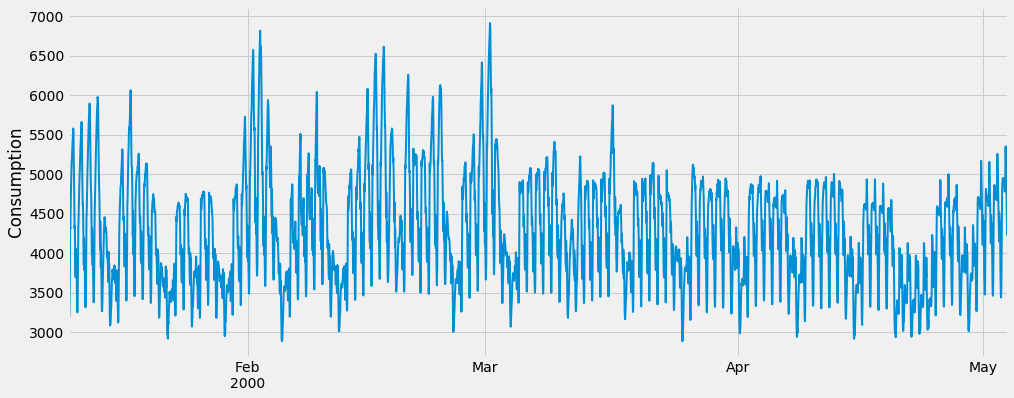

In [7]:
df['Consumption'].plot(figsize=(15, 6), 
                       lw=2)
plt.ylabel('Consumption')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


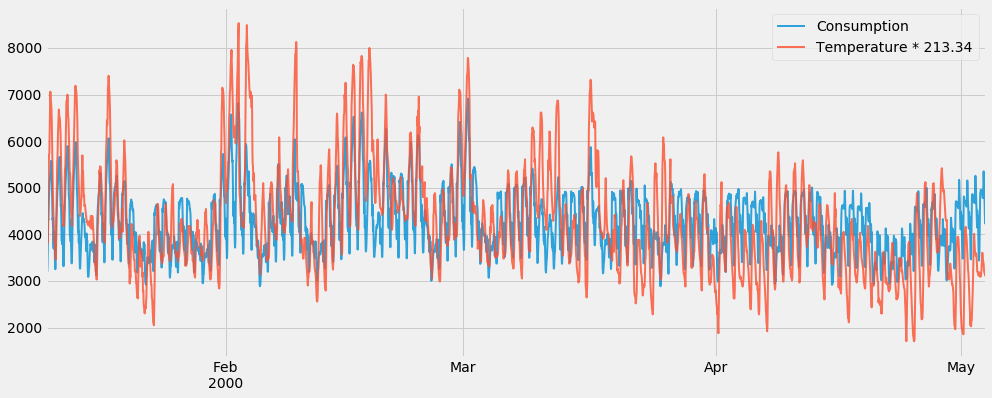

In [8]:
plot_df = df[['Consumption']]
coef = df['Consumption'].mean() / df['Temperature'].mean()
plot_df['Temperature * ' + 
        str(np.around(coef, 2))] = df['Temperature'] * coef

plot_df.plot(figsize=(15, 6), 
             alpha=0.8, 
             lw=2)
plt.show()

Теперь исследуем на кореляцию температуры и энергопотребления

Для начала посмотрим на точки этой зависимости

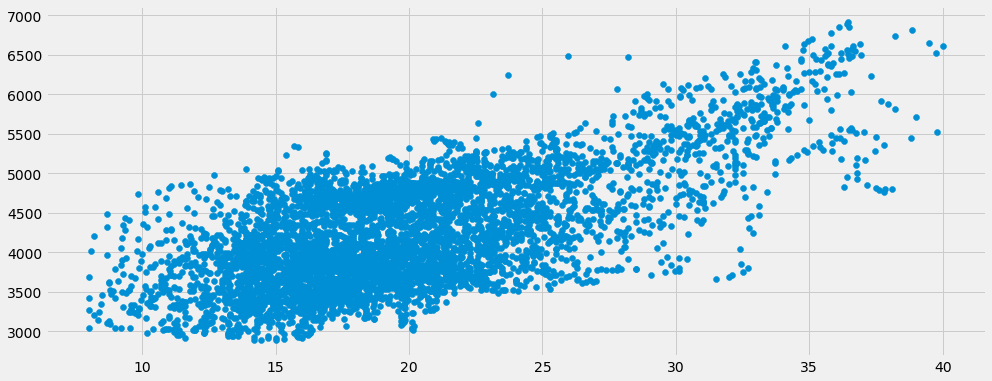

In [9]:
plt.figure(figsize=(15, 6))
plt.scatter(df['Temperature'], 
            df['Consumption'])
plt.show()

Можно заметить, что данные немного напоминают прямую, поэтому будем пользоваться гипотезой независимости

** Гипотеза независимости ** <br\>
$H_0$: выборки некоррелированы <br\>
$H_1$: выборки зависимы

Напишем функцию для визуализации кореляции

In [10]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [11]:
def visualize_correaltion(values1, values2):
    correlation = np.array([ sps.pearsonr  (values1, values2),
                             sps.spearmanr (values1, values2),
                             sps.kendalltau(values1, values2) ])
    
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(1, 3, 1)
    
    plt.scatter(values1, values2)
    plt.title('Sample')

    ax = fig.add_subplot(1, 3, 2)    
    plt.bar([0, 1, 2], correlation.T[0])
    plt.axhline(0, lw=1, c='black')
    
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['$\\hat{p}$', '$p_s$', '$\\tau$'])
    plt.ylim([-1, 1])
    plt.title('Correlation')

    ax = fig.add_subplot(1, 3, 3)
    plt.bar([0, 1, 2], correlation.T[1])
    plt.axhline(0.05, lw=1, c='red')
    
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['$\\hat{p}$', '$p_s$', '$\\tau$'])
    plt.ylim([0, 1])
    plt.title('Pvalue')

    plt.show()

In [12]:
def visualize_multipletest(result):
    print("Гипотеза отклоняется:", result[0])
    print("Скорректированные p-values:",result[1])
    
    print("\nГипотеза отклоняется:", np.all(result[0]))

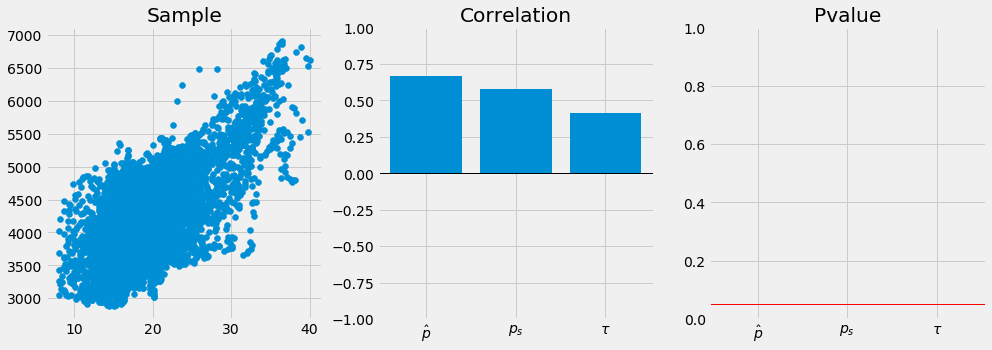

Гипотеза отклоняется: [ True  True  True  True  True  True  True  True  True  True]
Скорректированные p-values: [  4.92896400e-56   3.87087790e-72   9.17530012e-76   1.10042793e-60
   4.16793888e-78   2.86708177e-69   5.57925900e-71   9.43684095e-69
   1.60029429e-75   1.16408013e-62]

Гипотеза отклоняется: True

Гипотеза отклоняется: [ True  True  True  True  True  True  True  True  True  True]
Скорректированные p-values: [  2.93602093e-40   2.52859793e-47   4.79599096e-45   3.61371606e-45
   3.10623112e-56   2.59168743e-53   1.02457222e-45   7.04549723e-43
   4.40302176e-52   6.23495072e-43]

Гипотеза отклоняется: True

Гипотеза отклоняется: [ True  True  True  True  True  True  True  True  True  True]
Скорректированные p-values: [  1.89149304e-38   1.15135744e-44   1.82099096e-43   2.72501434e-43
   4.08886420e-52   7.64993371e-50   1.62496157e-43   5.15301814e-42
   5.93553744e-49   9.43378881e-41]

Гипотеза отклоняется: True



In [13]:
visualize_correaltion(df['Temperature'], df['Consumption'])

pvalues = [[], [], []]
for test in range(10):
    inds = np.random.choice(len(df), int(len(df) / 10))
    
    correlation = np.array([ sps.pearsonr  (df['Temperature'].iloc[inds], 
                                            df['Consumption'].iloc[inds]),
                             sps.spearmanr (df['Temperature'].iloc[inds], 
                                            df['Consumption'].iloc[inds]),
                             sps.kendalltau(df['Temperature'].iloc[inds], 
                                            df['Consumption'].iloc[inds]) ])
    
    for i in range(3):
        pvalues[i].append(correlation[i][1])

for i in range(3):
    visualize_multipletest(multipletests(pvalues[i], method='bonferroni'))
    print()

# TODO

<span>2.</span> Разделите временной ряд на две части: данные за последнюю неделю (последние $48*7$ измерений) назовем тестовыми данными, а все остальное — обучающими данными. 

In [14]:
train_df = df.iloc[:-48 * 7]
test_df  = df.iloc[-48 * 7:]

<span>3.</span> Сколько типов сезонностей можно выделить в каждом из двух рядов (спрос на электричество и температура)? С помощью $STL$-декомпозиции в каждом ряде выделите тренд, все типы сезонности, остатки.

In [15]:
def visualize_seasonal_decompose(decompose):
    fig = plt.figure(figsize=(15, 15))  
    
    ax = fig.add_subplot(4, 1, 1)
    decompose.observed.plot(lw=2)
    plt.ylabel("Observed")
    
    ax = fig.add_subplot(4, 1, 2)
    decompose.trend.plot(lw=2)
    plt.ylabel("Trend")
    
    ax = fig.add_subplot(4, 1, 3)
    decompose.seasonal.plot(lw=2)
    plt.ylabel("Seasonal")
    
    ax = fig.add_subplot(4, 1, 4)
    decompose.resid.plot(lw=2)
    plt.ylabel("Resid")
    
    plt.show()

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

Анализ временного ряда Температуры

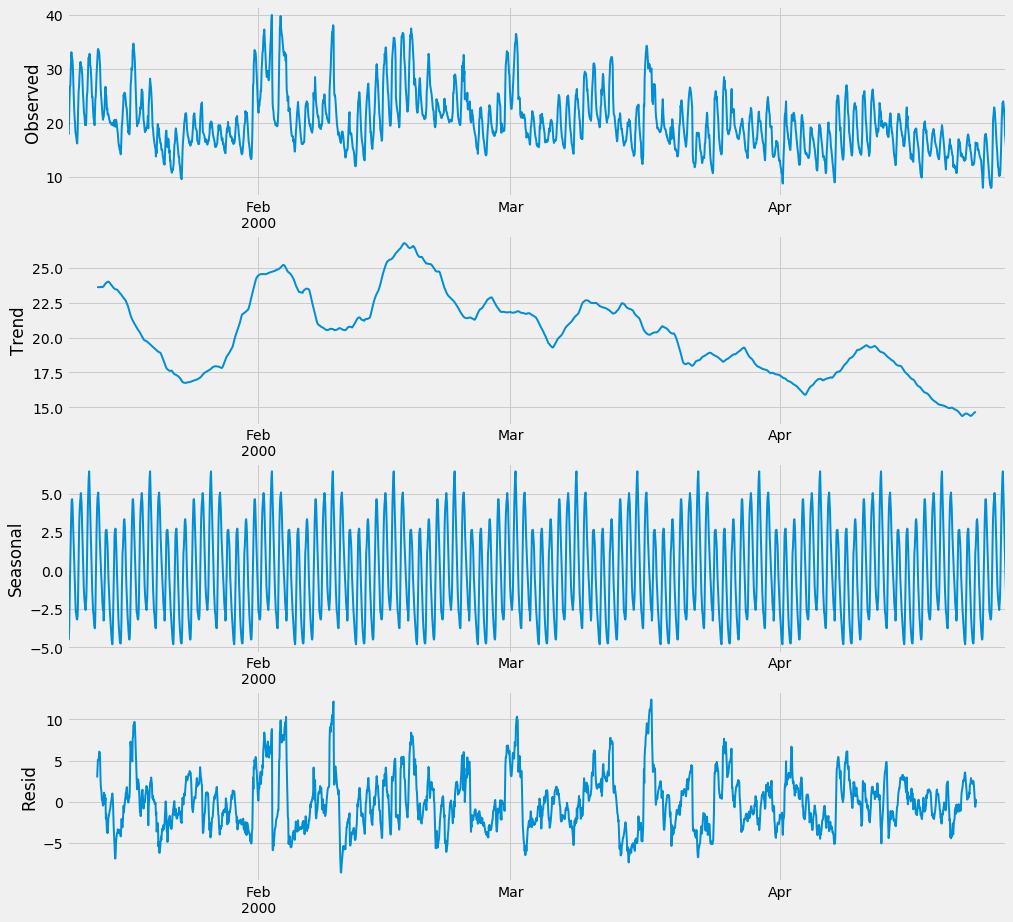

In [16]:
temperature_decompose_week = 
    seasonal_decompose(train_df['Temperature'], freq=48*7)
visualize_seasonal_decompose(temperature_decompose_week)

temperature_resid_week = 
    temperature_decompose_week.resid[np.isfinite(
        temperature_decompose_week.resid.values)]

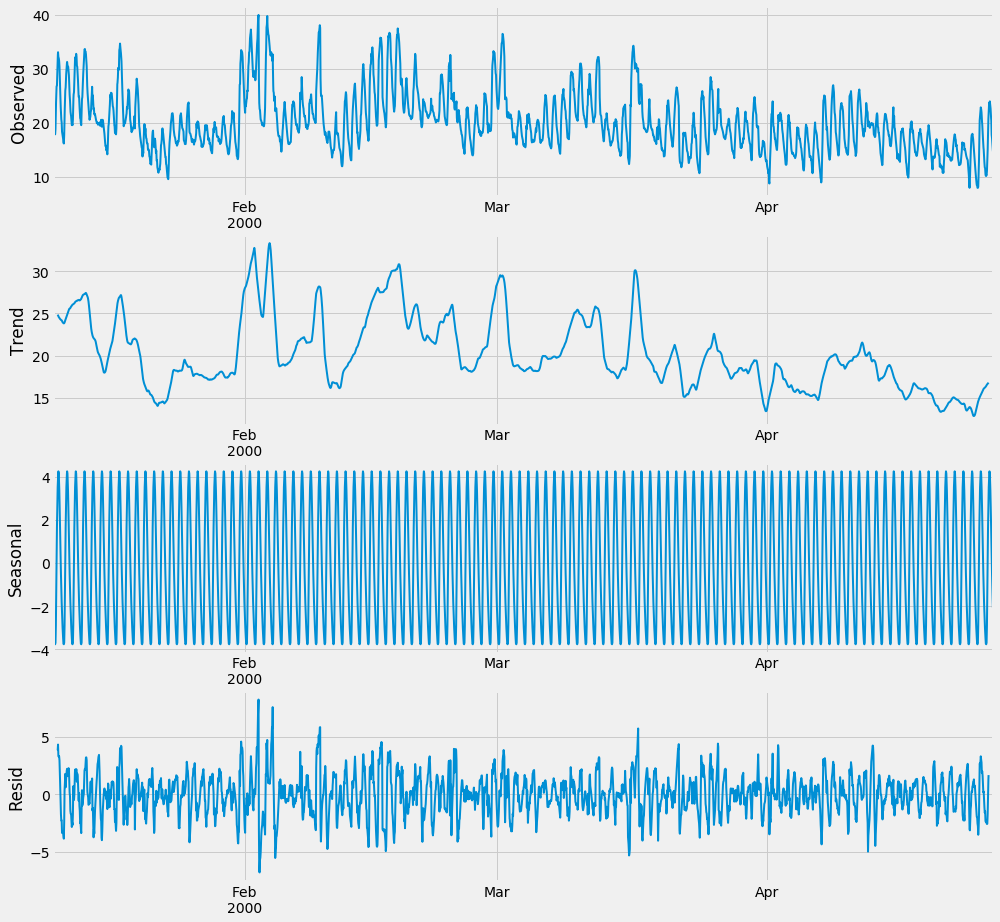

In [17]:
temperature_decompose_day = 
    seasonal_decompose(train_df['Temperature'], freq=48)
visualize_seasonal_decompose(temperature_decompose_day)

temperature_resid_day = 
    temperature_decompose_day.resid[np.isfinite(
        temperature_decompose_day.resid.values)]

Анализ временного ряда Потребления

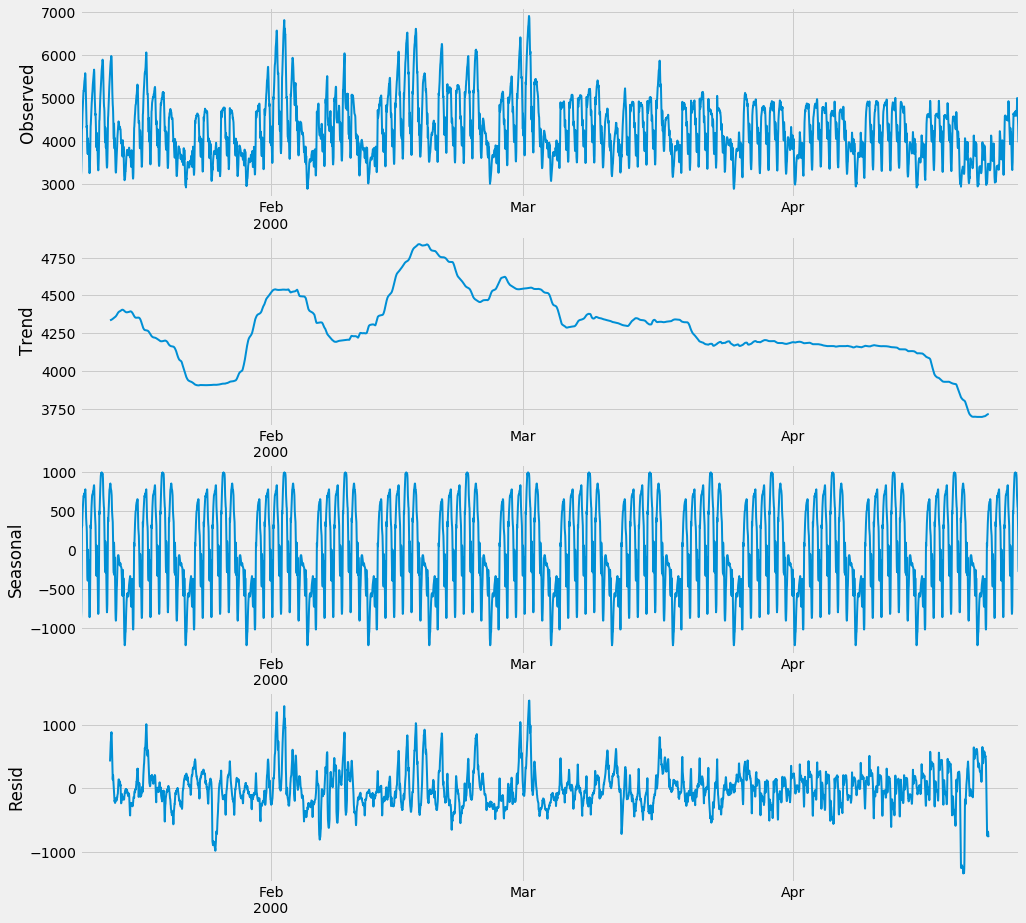

In [18]:
consumption_decompose_week = 
    seasonal_decompose(train_df['Consumption'], freq=48*7)
visualize_seasonal_decompose(consumption_decompose_week)

consumption_resid_week = 
    consumption_decompose_week.resid[np.isfinite(
        consumption_decompose_week.resid.values)]

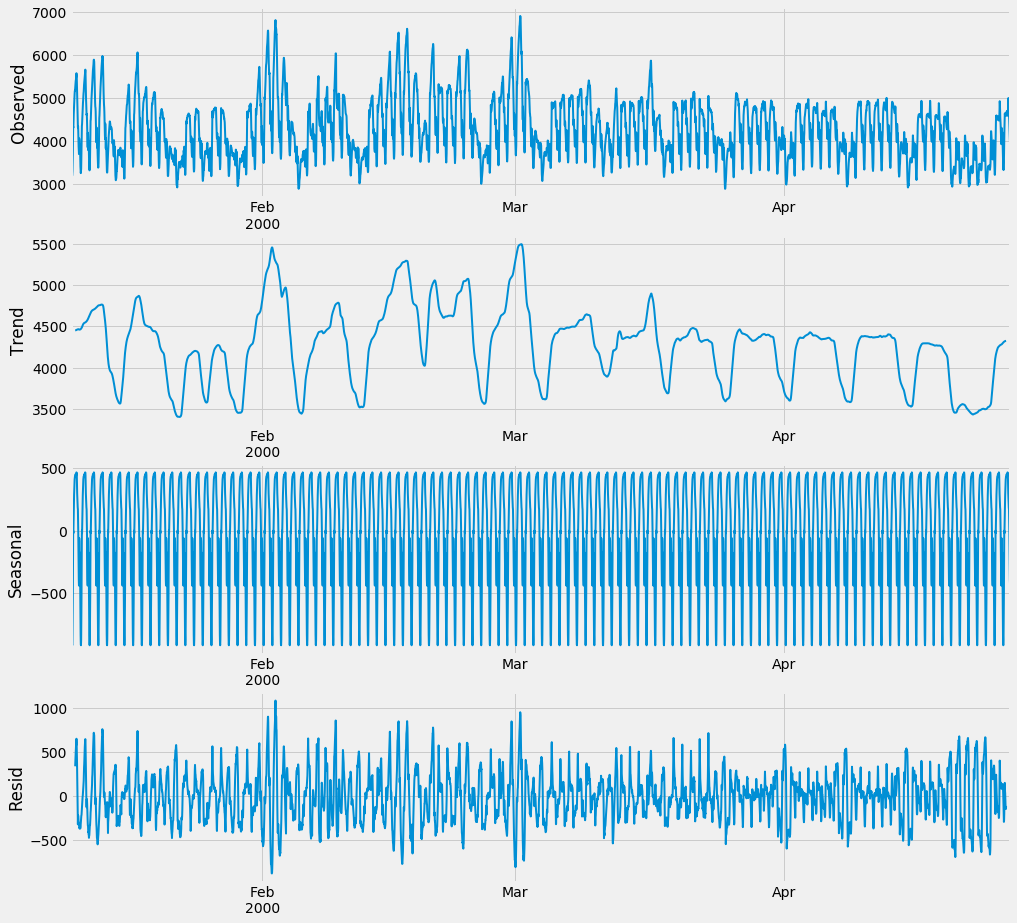

In [19]:
consumption_decompose_day = 
    seasonal_decompose(train_df['Consumption'], freq=48)
visualize_seasonal_decompose(consumption_decompose_day)

consumption_resid_day = 
    consumption_decompose_day.resid[
        np.isfinite(consumption_decompose_day.resid.values)]

<span>4.</span> С помощью критерия KPSS проверьте на стационарность исходные ряды и остатки, полученные после применения $STL$-декомпозиции. Не забывайте про множественную проверку гипотез.

** Гипотеза ** <br\>
$H_0$: ряд стационарен <br\>
$H_1$: ряд описывается моделью вида $y_t = \alpha y_{t-1}$

In [20]:
from statsmodels.tsa.stattools import kpss

In [17]:
def stationarity_check(values):
    result = kpss(values)
    print(result)
    print("Гипотеза отклоняется:", 
          result[1] < 0.05, end="\n\n")

    pvalues = []
    for test in range(10):
        part = int(len(train_df) / 10)
        pvalues.append(
            kpss(
                values[test * part:(test + 1) * part])[1])

    visualize_multipletest(
        multipletests(
            np.array(pvalues)/len(pvalues), 
            method='bonferroni'))

In [22]:
stationarity_check(train_df['Temperature'].values)

(3.3025613539810768, 0.01, 33, {'1%': 0.739, '10%': 0.347, '5%': 0.463, '2.5%': 0.574})
Гипотеза отклоняется: True

Гипотеза отклоняется: [False  True  True  True False  True False  True False False]
Скорректированные p-values: [ 0.05781762  0.01824677  0.01        0.01002732  0.1         0.03057066
  0.06643681  0.01        0.1         0.1       ]

Гипотеза отклоняется: False


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [23]:
stationarity_check(temperature_resid_week)

(0.01654585169215558, 0.1, 32, {'1%': 0.739, '10%': 0.347, '5%': 0.463, '2.5%': 0.574})
Гипотеза отклоняется: False

Гипотеза отклоняется: [False  True False False False False False False False  True]
Скорректированные p-values: [ 0.1         0.01852471  0.1         0.1         0.1         0.1         0.1
  0.1         0.1         0.02917793]

Гипотеза отклоняется: False


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [24]:
stationarity_check(temperature_resid_day)

(0.0066484742102167274, 0.1, 33, {'1%': 0.739, '10%': 0.347, '5%': 0.463, '2.5%': 0.574})
Гипотеза отклоняется: False

Гипотеза отклоняется: [False False False False False False False False False False]
Скорректированные p-values: [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]

Гипотеза отклоняется: False


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [25]:
stationarity_check(train_df['Consumption'].values)

(0.98874779975401406, 0.01, 33, {'1%': 0.739, '10%': 0.347, '5%': 0.463, '2.5%': 0.574})
Гипотеза отклоняется: True

Гипотеза отклоняется: [False False  True  True False False False False False  True]
Скорректированные p-values: [ 0.1         0.1         0.04587338  0.03454652  0.1         0.1         0.1
  0.1         0.1         0.0403611 ]

Гипотеза отклоняется: False


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [26]:
stationarity_check(consumption_resid_week)

(0.017763900134228409, 0.1, 32, {'1%': 0.739, '10%': 0.347, '5%': 0.463, '2.5%': 0.574})
Гипотеза отклоняется: False

Гипотеза отклоняется: [False  True False False False False False False False False]
Скорректированные p-values: [ 0.1         0.01        0.1         0.1         0.1         0.1         0.1
  0.1         0.1         0.09417342]

Гипотеза отклоняется: False


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [27]:
stationarity_check(consumption_resid_day)

(0.0035004299103796334, 0.1, 33, {'1%': 0.739, '10%': 0.347, '5%': 0.463, '2.5%': 0.574})
Гипотеза отклоняется: False

Гипотеза отклоняется: [False False False False False False False False False False]
Скорректированные p-values: [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]

Гипотеза отклоняется: False


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


<span>5.</span> С помощью преобразований исходных рядов приведите их к стационарным. По графикам $ACF$ и $PACF$ подберите параметры модели $SARIMA\left(p, d, q\right) \times \left(P, D, Q\right)_s$.

In [28]:
def autocorrelation(data):
    fig = plt.figure(figsize=(15, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(
        data, lags=50, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(
        data, lags=50, ax=ax2)
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.0035793857128195226, 0.1, 33, {'1%': 0.739, '10%': 0.347, '5%': 0.463, '2.5%': 0.574})
Гипотеза отклоняется: False

Гипотеза отклоняется: [False False False False False False False False False False]
Скорректированные p-values: [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]

Гипотеза отклоняется: False


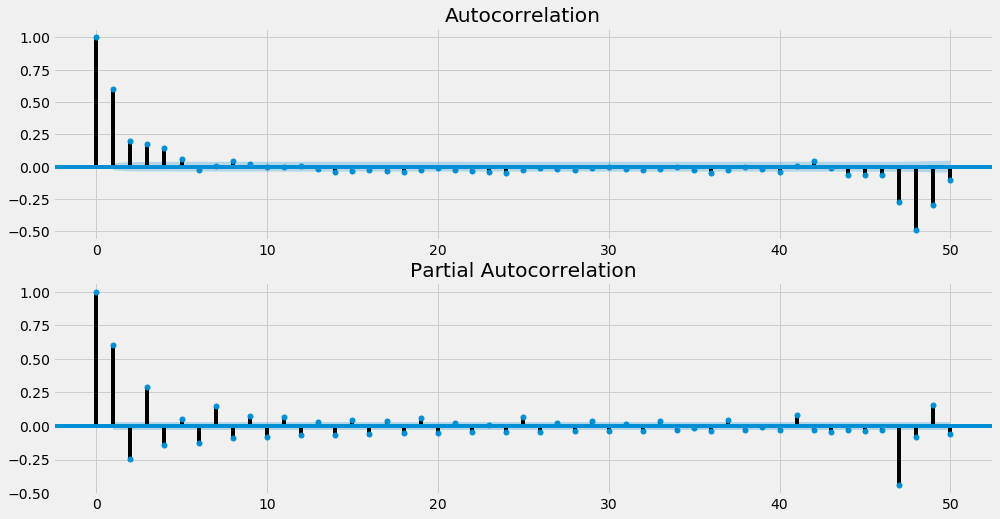

In [29]:
temperature = np.array(train_df['Temperature'])

temperature = temperature[48:] - temperature[:-48]
temperature = temperature[1:] - temperature[:-1]

stationarity_check(temperature)
autocorrelation(temperature)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.0047888883620005075, 0.1, 32, {'1%': 0.739, '10%': 0.347, '5%': 0.463, '2.5%': 0.574})
Гипотеза отклоняется: False

Гипотеза отклоняется: [False False False False False False False False False False]
Скорректированные p-values: [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]

Гипотеза отклоняется: False


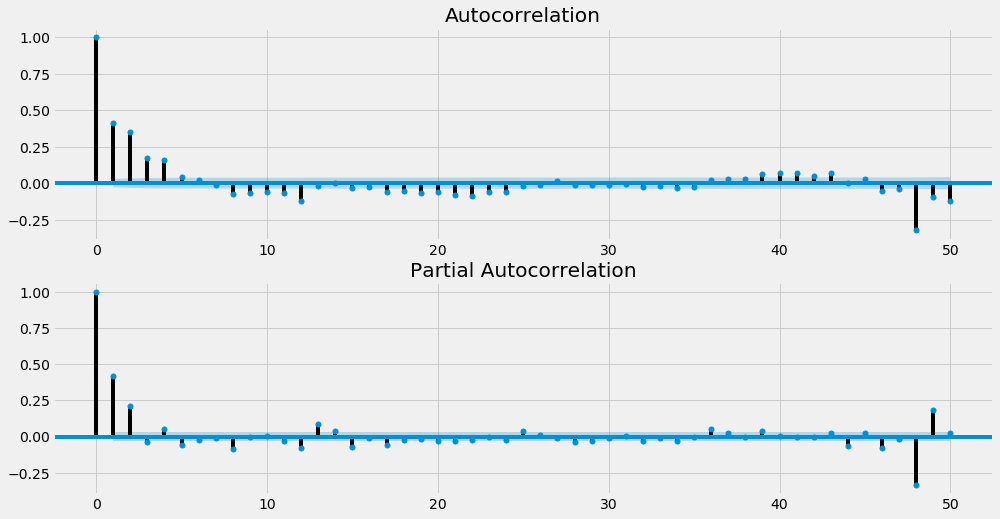

In [30]:
consumption = np.array(train_df['Consumption'])

consumption = consumption[48*7:] - consumption[:-48*7]
consumption = consumption[48:] - consumption[:-48]
consumption = consumption[1:] - consumption[:-1]

stationarity_check(consumption)
autocorrelation(consumption)

<span>6.</span> С помощью поиска по сетке вокруг выбранных параметров подберите оптимальные параметры по значению $AIC$. Учтите, что из сделанных ранее преобразований ряда нужно оставить лишь некоторые. Другие, например, одна из сезонностей будут учтены параметрами модели.

Посмотрим сначала на временной ряд температуры, и предположим что он имеет только одну сезонность по дням

In [34]:
q = range(4, 7)
p = range(2, 5)
d = [1]

Q = range(0, 2)
P = range(0, 2)
D = [1]

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 48) 
                for x in list(itertools.product(P, D, Q))]

In [62]:
warnings.filterwarnings('ignore')

temperature = np.array(train_df['Temperature'])

for param in tqdm_notebook(pdq):
    for param_seasonal in tqdm_notebook(seasonal_pdq, leave=False):
        try:
            model = 
            sm.tsa.statespace.SARIMAX(temperature, 
                                      order=param, 
                                      seasonal_order=param_seasonal, 
                                      enforce_stationarity=False, 
                                      enforce_invertibility=False)
            model = model.fit()
            print('ARIMA{}x{}48 – AIC:{}'.format(
                param, param_seasonal, model.aic))
        except Exception as e:
            print(e)
            continue

ARIMA(2, 1, 4)x(0, 1, 0, 48)48 – AIC:6143.92601655518
ARIMA(2, 1, 4)x(0, 1, 1, 48)48 – AIC:2996.3134093997496
ARIMA(2, 1, 4)x(1, 1, 0, 48)48 – AIC:4614.959047021907
ARIMA(2, 1, 4)x(1, 1, 1, 48)48 – AIC:2994.5006779067458
ARIMA(2, 1, 5)x(0, 1, 0, 48)48 – AIC:6032.203364460167
ARIMA(2, 1, 5)x(0, 1, 1, 48)48 – AIC:2965.6196117057234
ARIMA(2, 1, 5)x(1, 1, 0, 48)48 – AIC:4571.4079750151595
ARIMA(2, 1, 5)x(1, 1, 1, 48)48 – AIC:2958.2789614665057
ARIMA(2, 1, 6)x(0, 1, 0, 48)48 – AIC:6039.581942438682
ARIMA(2, 1, 6)x(0, 1, 1, 48)48 – AIC:2966.274377809079
ARIMA(2, 1, 6)x(1, 1, 0, 48)48 – AIC:4574.607264221253
ARIMA(2, 1, 6)x(1, 1, 1, 48)48 – AIC:2950.2411088972526
ARIMA(3, 1, 4)x(0, 1, 0, 48)48 – AIC:6050.1182014974
ARIMA(3, 1, 4)x(0, 1, 1, 48)48 – AIC:2966.853647711018
ARIMA(3, 1, 4)x(1, 1, 0, 48)48 – AIC:4577.180950947133
ARIMA(3, 1, 4)x(1, 1, 1, 48)48 – AIC:2979.8591225718974
ARIMA(3, 1, 5)x(0, 1, 0, 48)48 – AIC:6032.690415337867
ARIMA(3, 1, 5)x(0, 1, 1, 48)48 – AIC:2971.4425945860094
ARIMA

Минимум достигается на `ARIMA(3, 1, 6)x(0, 1, 1, 48)48 – AIC:2929.2095091748765`

<span>7.</span> Постройте прогнозы модели с оптимальными параметрами на неделю вперед. Посчитайте качество прогноза по сравнению с реальными данными на тестовом интервале, используя метрику $MSE$ (см. презентацию).

In [63]:
model = sm.tsa.statespace.SARIMAX(train_df['Temperature'], 
                                  order=(3, 1, 6), 
                                  seasonal_order=(0, 1, 1, 48),
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False)
model = model.fit()
print(model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1871      0.442      2.686      0.007       0.321       2.053
ar.L2         -0.1534      0.600     -0.255      0.798      -1.330       1.023
ar.L3         -0.0517      0.172     -0.300      0.764      -0.389       0.286
ma.L1         -0.1952      0.450     -0.434      0.664      -1.076       0.686
ma.L2         -0.8331      0.252     -3.302      0.001      -1.328      -0.339
ma.L3          0.1656      0.356      0.466      0.641      -0.531       0.862
ma.L4         -0.0209      0.143     -0.146      0.884      -0.301       0.260
ma.L5          0.0313      0.120      0.262      0.794      -0.203       0.266
ma.L6         -0.1442      0.042     -3.448      0.001      -0.226      -0.062
ma.S.L48      -0.9726      0.004   -235.992      0.000      -0.981      -0.965
sigma2         0.1013      0.015      6.759      0.0

In [64]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        Temperature   No. Observations:                 5184
Model:             SARIMAX(3, 1, 6)x(0, 1, 1, 48)   Log Likelihood               -1453.605
Date:                            Fri, 08 Dec 2017   AIC                           2929.210
Time:                                    17:29:32   BIC                           3001.296
Sample:                                01-10-2000   HQIC                          2954.429
                                     - 04-26-2000                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1871      0.442      2.686      0.007       0.321       2.053
ar.L2         -0.1534      0.600     -0.255      0.798      -1.330       1.023
ar.L3         -0.0517      0.172     -0.300      0.764      -0.389       0.286
ma.L1         -0.1952      0.450     -0.434      0.664      -1.076       0.686
ma.L2         -0.8331      0.252     -3.302      0.001      -1.328      -0.339
ma.L3          0.1656      0.356      0.466      0.641      -0.531       0.862
ma.L4         -0.0209      0.143     -0.146      0.884      -0.301       0.260
ma.L5          0.0313      0.120      0.262      0.794      -0.203       0.266
ma.L6         -0.1442      0.042     -3.448      0.001      -0.226      -0.062
ma.S.L48      -0.9726      0.004   -235.992      0.000      -0.981      -0.965
sigma2         0.1013      0.015      6.759      0.000       0.072       0.131
===================================================================================
Ljung-Box (Q):                      111.47   Jarque-Bera (JB):            356447.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                            -2.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

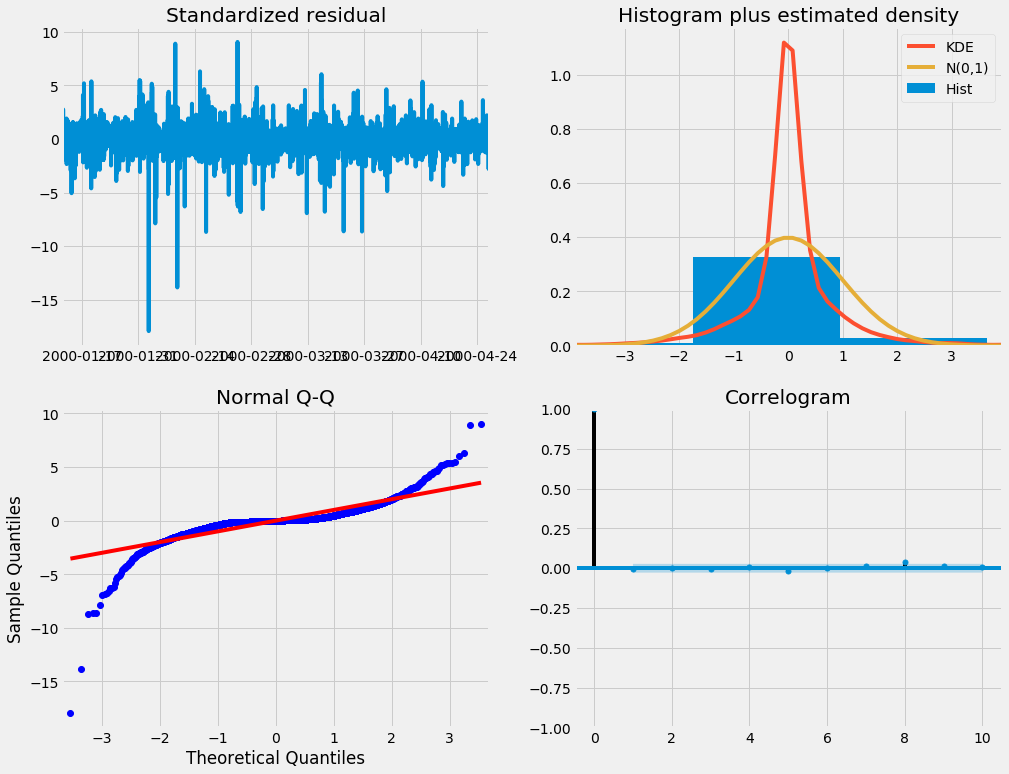

In [65]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

Получилось не очень, не смотря на то, что это лучший вариант из сетки

Посмотрим на статические и динамические предсказания

In [66]:
pred = model.get_prediction(start=pd.to_datetime('2000-04-19'), 
                            dynamic=False)
pred_ci = pred.conf_int()

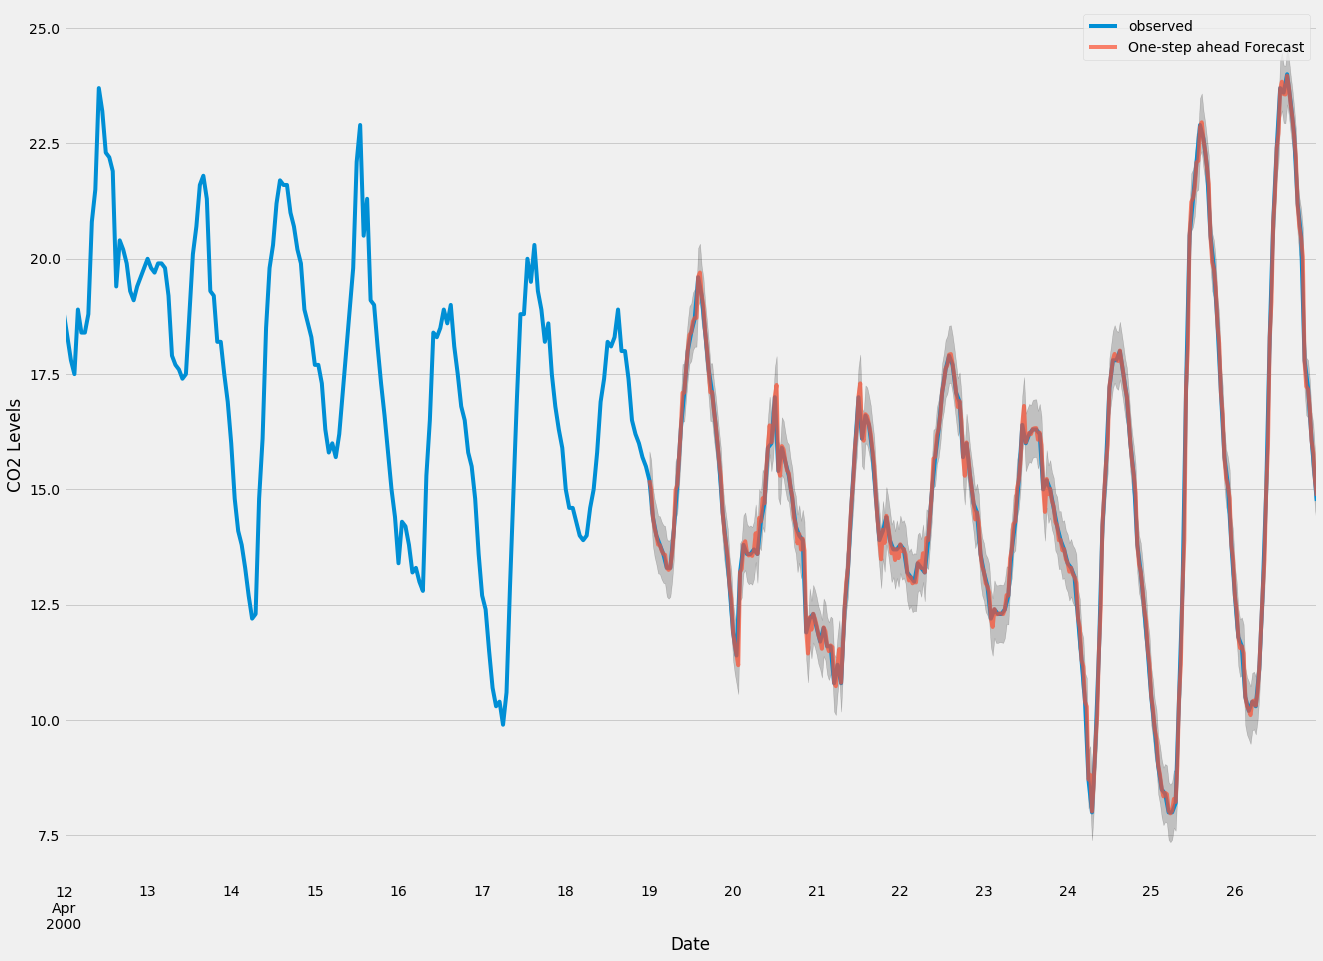

In [67]:
ax = train_df['Temperature']['2000-04-12':].plot(
    label='observed', figsize=(20, 15))
pred.predicted_mean.plot(ax=ax, 
                         label='One-step ahead Forecast', 
                         alpha=.7)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], 
                color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

In [68]:
pred_dynamic = model.get_prediction(
    start=pd.to_datetime('2000-04-19'), 
    dynamic=True, 
    full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

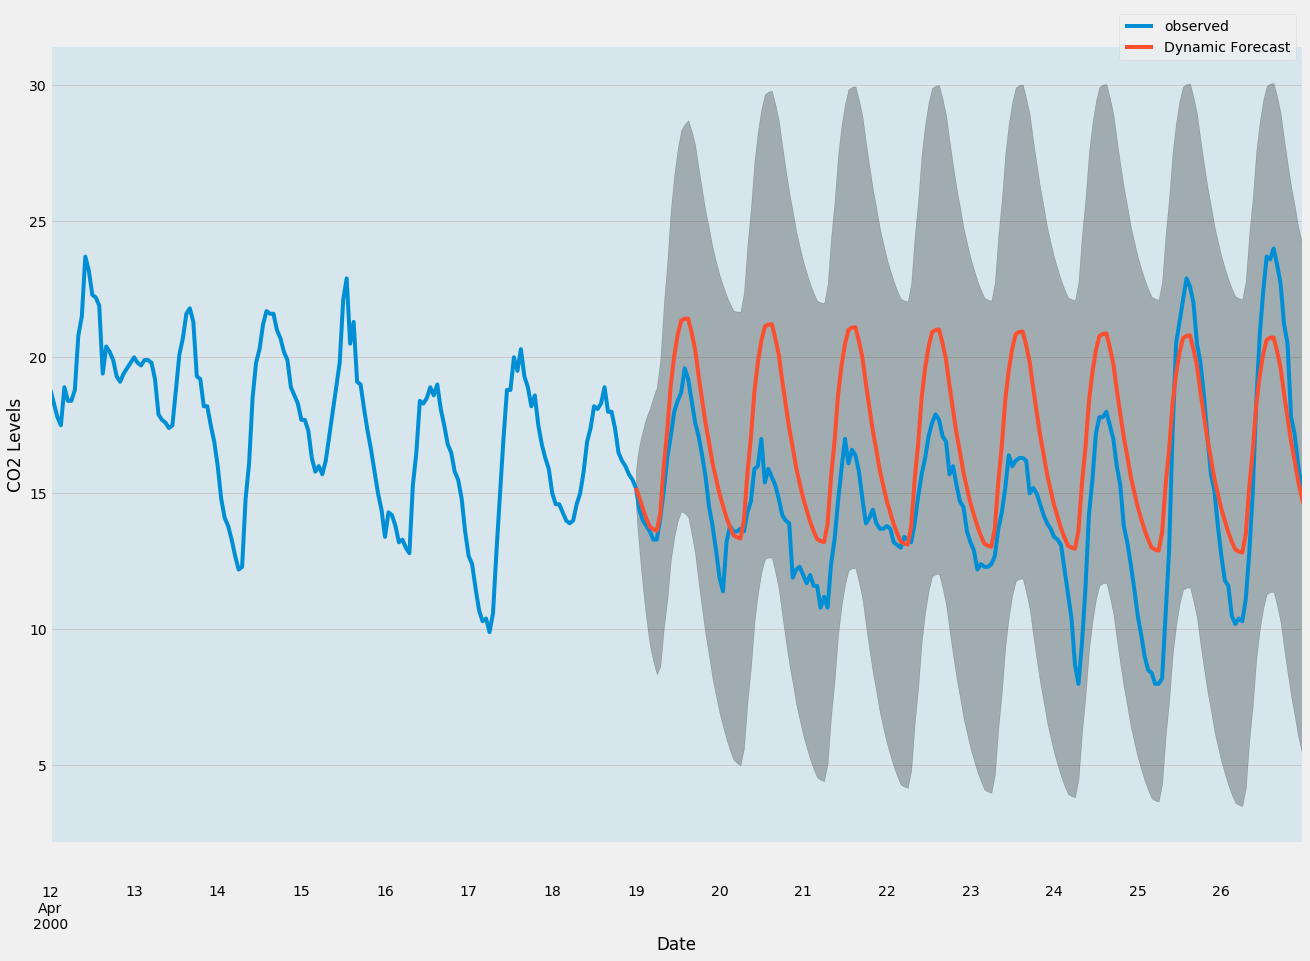

In [69]:
ax = train_df['Temperature']['2000-04-12':].plot(
    label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(
    label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index, 
                pred_dynamic_ci.iloc[:, 0], 
                pred_dynamic_ci.iloc[:, 1], 
                color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('1998-01-01'), 
                 train_df['Temperature'].index[-1], 
                 alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

Наконец, предскажем на неделю вперед

In [70]:
# прогноз на неделю вперед
pred_uc = model.get_forecast(steps=48*7)
pred_ci = pred_uc.conf_int()

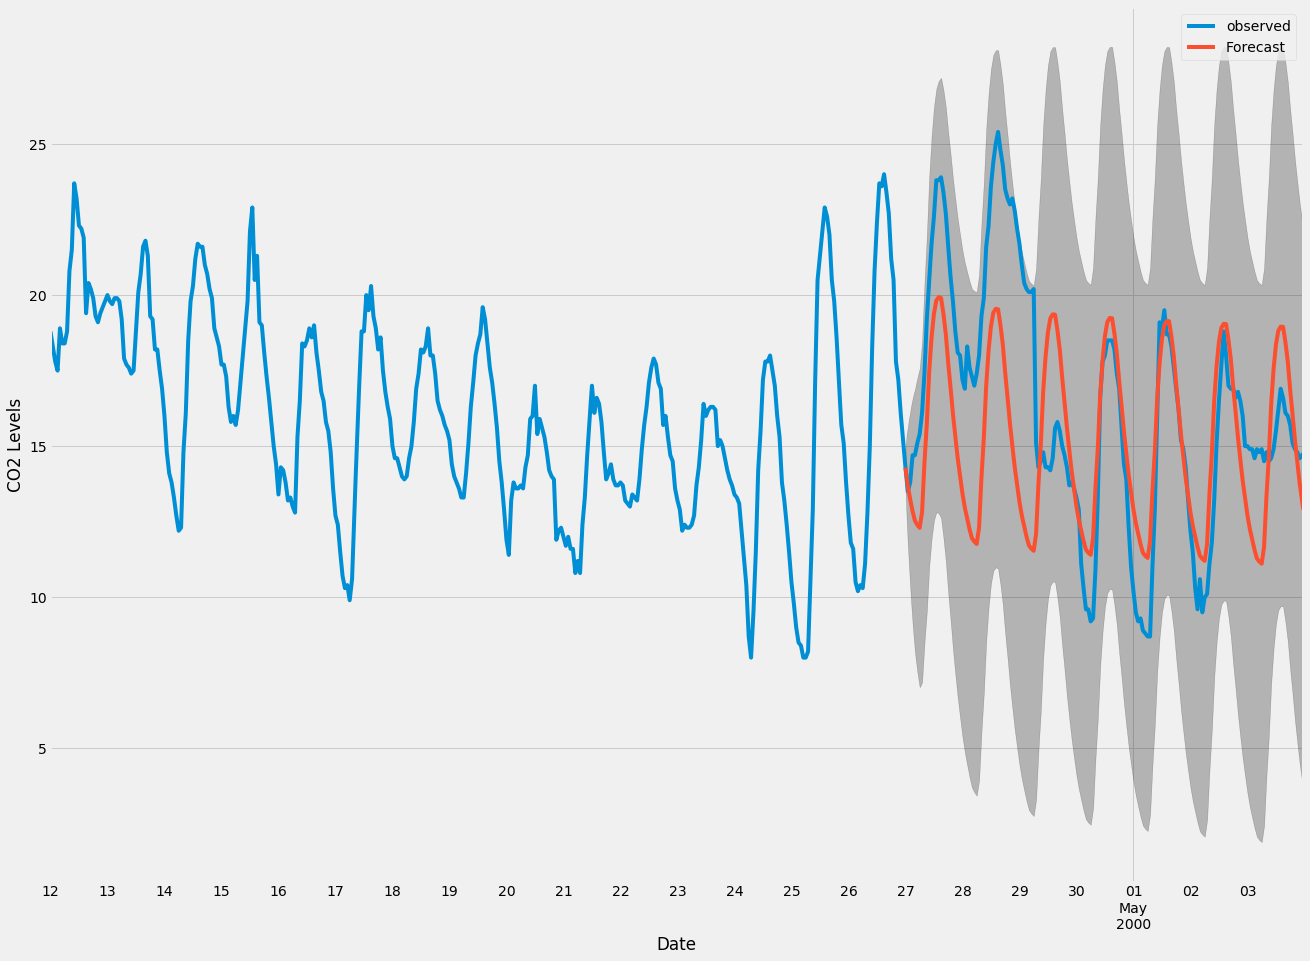

In [71]:
ax = df['Temperature']['2000-04-12':].plot(
    label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(
    ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], 
                color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

In [75]:
# извлекаем прогнозированные и верные значения нашего временного ряда
y_forecasted = pred_uc.predicted_mean
y_truth = test_df["Temperature"].values
# вычисляем среднеквадратичную ошибку
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.
      format(round(mse, 2)))

The Mean Squared Error of our forecasts is 11.95


Теперь посмотрим на ряд потребления

In [32]:
q = range(4, 7)
p = range(2, 5)
d = [1]

Q = range(0, 2)
P = range(0, 2)
D = [1]

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 48) 
                for x in list(itertools.product(P, D, Q))]

In [33]:
warnings.filterwarnings('ignore')

consumption = np.array(train_df["Consumption"])
consumption = consumption[48*7:] - consumption[:-48*7]

for param in tqdm_notebook(pdq):
    for param_seasonal in tqdm_notebook(seasonal_pdq, leave=False):
        try:
            model = 
            sm.tsa.statespace.SARIMAX(consumption, 
                                      order=param, 
                                      seasonal_order=param_seasonal, 
                                      enforce_stationarity=False, 
                                      enforce_invertibility=False)
            model = model.fit()
            print('ARIMA{}x{}48 – AIC:{}'.
                  format(param, param_seasonal, model.aic))
        except Exception as e:
            print(e)
            continue

ARIMA(2, 1, 4)x(0, 1, 0, 48)48 – AIC:11645.567036636687
ARIMA(2, 1, 4)x(0, 1, 1, 48)48 – AIC:6243.872205884085
ARIMA(2, 1, 4)x(1, 1, 0, 48)48 – AIC:8586.952192261764
ARIMA(2, 1, 4)x(1, 1, 1, 48)48 – AIC:4854.652431625199
ARIMA(2, 1, 5)x(0, 1, 0, 48)48 – AIC:11645.312453799048
ARIMA(2, 1, 5)x(0, 1, 1, 48)48 – AIC:6244.405113625916
ARIMA(2, 1, 5)x(1, 1, 0, 48)48 – AIC:8588.952212469074



KeyboardInterrupt: 

Не успею уже посчитать :(

In [21]:
q = [6]
p = [3]
d = [1]

Q = range(1, 4)
P = range(1, 3)
D = [1]

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 48) 
                for x in list(itertools.product(P, D, Q))]

In [22]:
warnings.filterwarnings('ignore')

consumption = np.array(train_df["Consumption"])
consumption = consumption[48*7:] - consumption[:-48*7]

for param in tqdm_notebook(pdq):
    for param_seasonal in tqdm_notebook(seasonal_pdq, leave=False):
        try:
            model = 
            sm.tsa.statespace.SARIMAX(consumption, 
                                      order=param, 
                                      seasonal_order=param_seasonal, 
                                      enforce_stationarity=False, 
                                      enforce_invertibility=False)
            model = model.fit()
            print('ARIMA{}x{}48 – AIC:{}'.
                  format(param, param_seasonal, model.aic))
        except Exception as e:
            print(e)
            continue

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



ARIMA(3, 1, 6)x(1, 1, 1, 48)48 – AIC:51429.59954169387
ARIMA(3, 1, 6)x(1, 1, 2, 48)48 – AIC:51009.82271128708

Exception ignored in: <generator object __iter__ at 0x10b0c14c0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tqdm/_tqdm_notebook.py", line 186, in __iter__
    self.sp(bar_style='danger')
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tqdm/_tqdm_notebook.py", line 142, in print_status
    pbar.bar_style = bar_style
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/traitlets/traitlets.py", line 583, in __set__
    self.set(obj, value)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/traitlets/traitlets.py", line 572, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/traitlets/traitlets.py", line 1137, in _notify_trait
    type='change',
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-ac2fc6eef540>", line 12, in <module>
    model = model.fit()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/tsa/statespace/mlemodel.py", line 446, in fit
    skip_hessian=True, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/base/model.py", line 451, in fit
    full_output=full_output)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/base/optimizer.py", line 184, in _fit
    hess=hessian)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/base/optimizer.py", line 378, in _fit_lbfgs
    **extra_kwargs)
  File "/Library/Frameworks

KeyboardInterrupt: 

А тут еще и ошибки

Возьмем какие-нибудь параметры, похожие на правду, предварительно снимим недельную сезонность

In [23]:
consumption = np.array(train_df["Consumption"])
consumption = consumption[48*7:] - consumption[:-48*7]

model = sm.tsa.statespace.SARIMAX(consumption, 
                                  order=(3, 1, 6), 
                                  seasonal_order=(0, 1, 1, 48),
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False)
model = model.fit()
print(model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1377      0.083      1.657      0.098      -0.025       0.301
ar.L2         -0.4804      0.079     -6.090      0.000      -0.635      -0.326
ar.L3          0.5314      0.052     10.231      0.000       0.430       0.633
ma.L1          0.2320      0.084      2.762      0.006       0.067       0.397
ma.L2          0.8093      0.089      9.126      0.000       0.635       0.983
ma.L3         -0.2283      0.077     -2.978      0.003      -0.378      -0.078
ma.L4          0.1752      0.046      3.784      0.000       0.084       0.266
ma.L5         -0.0637      0.032     -2.017      0.044      -0.126      -0.002
ma.L6          0.0751      0.023      3.239      0.001       0.030       0.120
ma.S.L48      -0.4969      0.003   -144.090      0.000      -0.504      -0.490
sigma2      3259.0212     19.816    164.462      0.0

In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 4848
Model:             SARIMAX(3, 1, 6)x(0, 1, 1, 48)   Log Likelihood              -25878.650
Date:                            Fri, 08 Dec 2017   AIC                          51779.299
Time:                                    16:38:15   BIC                          51850.649
Sample:                                         0   HQIC                         51804.345
                                           - 4848                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1377      0.083      1.657      0.098      -0.025       0.301
ar.L2         -0.4804      0.079     -6.090      0.000      -0.635      -0.326
ar.L3          0.5314      0.052     10.231      0.000       0.430       0.633
ma.L1          0.2320      0.084      2.762      0.006       0.067       0.397
ma.L2          0.8093      0.089      9.126      0.000       0.635       0.983
ma.L3         -0.2283      0.077     -2.978      0.003      -0.378      -0.078
ma.L4          0.1752      0.046      3.784      0.000       0.084       0.266
ma.L5         -0.0637      0.032     -2.017      0.044      -0.126      -0.002
ma.L6          0.0751      0.023      3.239      0.001       0.030       0.120
ma.S.L48      -0.4969      0.003   -144.090      0.000      -0.504      -0.490
sigma2      3259.0212     19.816    164.462      0.000    3220.182    3297.860
===================================================================================
Ljung-Box (Q):                      175.43   Jarque-Bera (JB):            243605.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

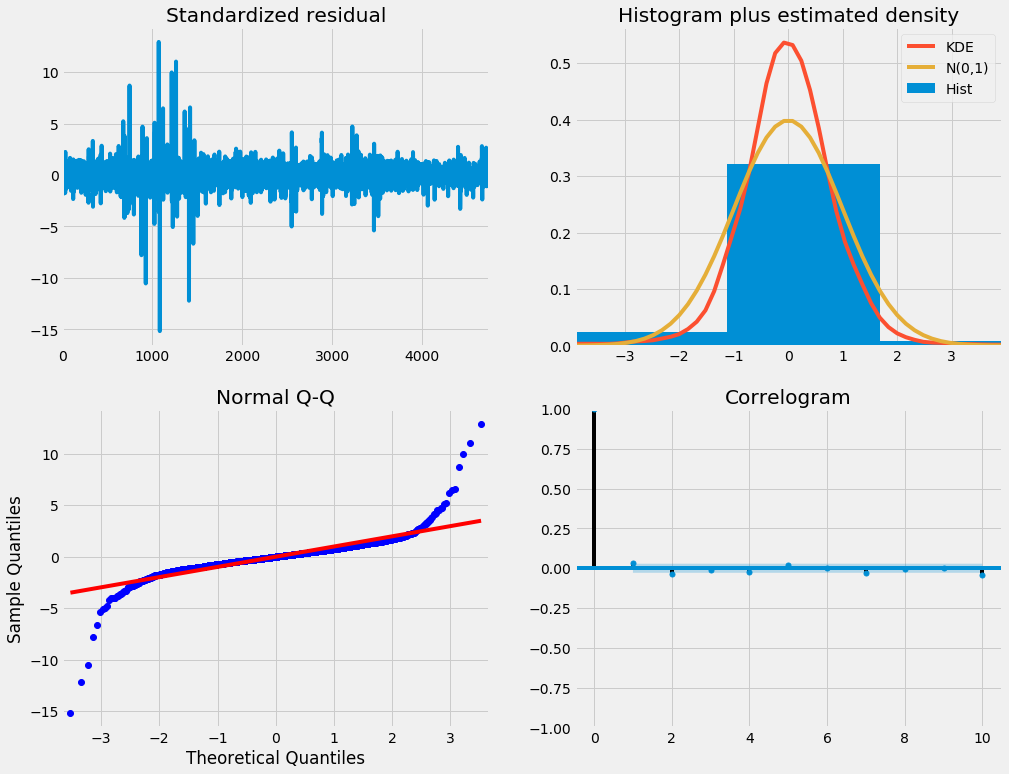

In [25]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

На самом деле тут даже более похоже, чем было в температурой

In [26]:
# прогноз на неделю вперед
pred_uc = model.get_forecast(steps=48*7)
pred_ci = pred_uc.conf_int()

In [34]:
test_df.head()

,Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
2000-04-27 00:00:00,5184,4154.970201,14.30,5184,0,192
2000-04-27 00:30:00,5185,4008.652480,13.90,5185,1,193
2000-04-27 01:00:00,5186,4210.425512,13.50,5186,2,194
2000-04-27 01:30:00,5187,4120.652307,13.65,5187,3,195
2000-04-27 02:00:00,5188,3882.215303,13.80,5188,4,196


Теперь спрогнозируем на неделю вперед

In [35]:
predicted_days = pd.date_range(start='2000-04-27 00:00:00', periods=48*7, freq='30T')
predicted = np.array(
    train_df["Consumption"])[-48*7:] + pred_uc.predicted_mean
predicted_ci = [np.array(
    train_df["Consumption"])[-48*7:] + pred_ci.iloc[:, 0],
                np.array(
                    train_df["Consumption"])[-48*7:] + pred_ci.iloc[:, 1]]

In [48]:
predicted_df = pd.DataFrame({'Datetime': predicted_days, 
                             "Consumption": predicted})
predicted_df.set_index('Datetime', inplace=True)

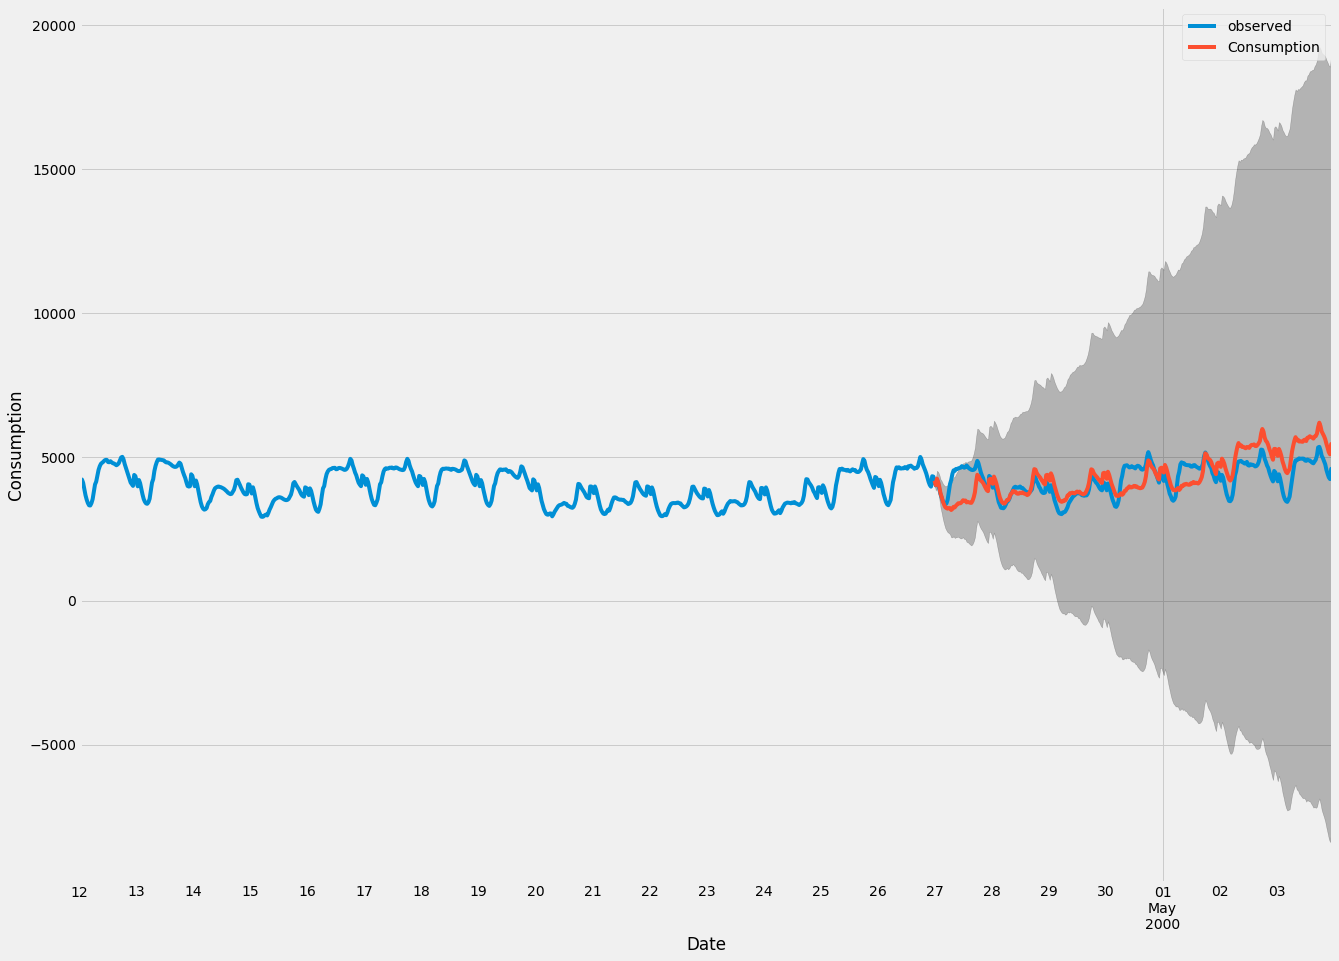

In [53]:
plt.figure(figsize=(15,6))
ax = df['Consumption']['2000-04-12':].
    plot(label='observed', figsize=(20, 15))
predicted_df.plot(ax=ax, label="Predicted");
ax.fill_between(predicted_days, 
                predicted_ci[0], 
                predicted_ci[1], 
                color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Consumption')
plt.legend()
plt.show()

Что-то не так с доверительным интервалом, наверное параметры все-таки не очень хорошие

In [62]:
# извлекаем прогнозированные и верные значения нашего временного ряда
y_forecasted = predicted_df["Consumption"].values
y_truth = test_df["Consumption"].values
# вычисляем среднеквадратичную ошибку
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.
        format(round(mse, 2)))

The Mean Squared Error of our forecasts is 349345.93


Ошибка получилось достаточно весомой, даже с учетом того что порядок величин тоже большой

<span>8.</span> Добавьте в модель предсказания электричества экзогенные факторы:

<span>(a)</span> Дневную и месячную сезонность (очевидно, они известны заранее). Однако, в том виде как они записаны в таблице применять не хорошо &mdash; может работать плохо, поэтому стоит использовать гармоники Фурье &mdash; синусы с периодом, делящим период сезонности. Их использование может позволить учесть сложные сезонности.

<span>(b)</span> Значения температуры, используя на тестовом интервале времени истинные значения температуры (нечестный способ).

<span>(c)</span> Значения температуры, используя на тестовом интервале времени предсказания значений температуры.

<span>(d)</span> Вместе (a) и (c).

<span>(e)</span> * Использование значений температуры по частям — для получения прогноза $\widehat{\text{y}}_T + h|_𝑇$ строится своя модель по временному ряду $y_h, \dots, y_𝑇$ с рядом экзогенного фактора $x_1, \dots, x_{𝑇−h}$.Тогда для получения прогноза𝑦 $\widehat{\text{y}}_T + h|_𝑇$ нужно знать значения $x_{𝑇−h+1}, \dots, x_𝑇$ , которые известны на момент построения модели.

<span>(f)</span> * Вместе (a) и (e).

<span>9.</span> Сравните все предсказания по метрике $MSE$.